# Systematic Strategy Diagnostics: Mean Reversion vs Time-Series Momentum

**Objective:**  
Evaluate whether simple mean-reversion and time-series momentum strategies
produce robust, cost-aware, out-of-sample performance on a diversified ETF universe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
meanrev_sens = pd.read_csv("../data/processed/meanrev_sensitivity.csv")
meanrev_sens.head()

meanrev_wf = pd.read_csv("../data/processed/meanrev_walkforward.csv")
meanrev_wf.head()

,train_start,train_end,test_start,test_end,Sharpe,CAGR,MaxDD,AvgTurnover,TotalCost,AvgGrossExposure,PctInvested
0,2006-01-01,2008-12-31,2009-01-02,2009-12-31,0.112489,0.003635,-0.024402,0.066009,0.016634,0.042978,0.055556
1,2007-01-01,2009-12-31,2010-01-04,2010-12-31,-0.696690,-0.029554,-0.072354,0.184977,0.046614,0.150165,0.178571
2,2008-01-01,2010-12-31,2011-01-03,2011-12-30,-0.875420,-0.044208,-0.068575,0.223481,0.056317,0.183530,0.218254
3,2009-01-01,2011-12-31,2012-01-03,2012-12-31,-3.288733,-0.162940,-0.163138,0.264239,0.066060,0.242381,0.264000
4,2010-01-01,2012-12-31,2013-01-02,2013-12-31,-2.697665,-0.158207,-0.165812,0.310927,0.078354,0.269814,0.301587


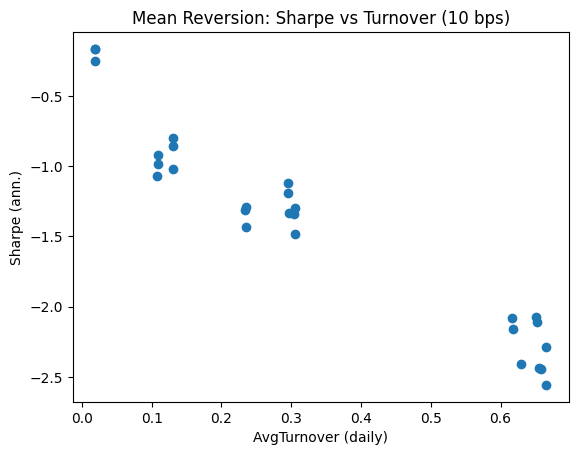

In [3]:
df = meanrev_sens.copy()
plt.figure()
plt.scatter(df["AvgTurnover"], df["Sharpe"])
plt.xlabel("AvgTurnover (daily)")
plt.ylabel("Sharpe (ann.)")
plt.title("Mean Reversion: Sharpe vs Turnover (10 bps)")
plt.show()

### Mean Reversion: Sensitivity Analysis (10 bps transaction costs)

**Observation:**
- Sharpe ratios are negative across the entire turnover spectrum.
- Lower turnover reduces losses but does not produce positive risk-adjusted returns.
- Higher turnover configurations degrade sharply, indicating cost amplification of a weak signal.

**Interpretation:**
Mean reversion in this universe appears structurally weak rather than merely cost-constrained.

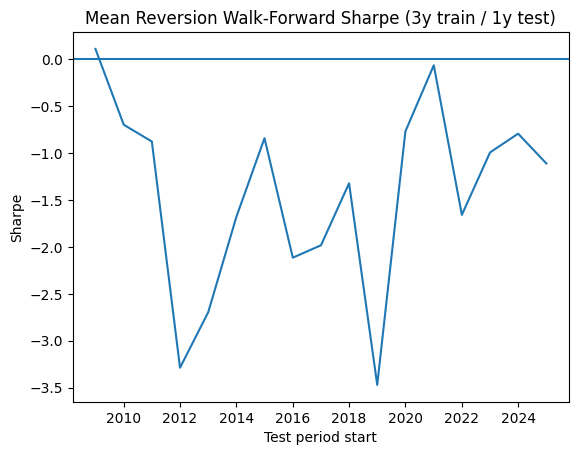

In [4]:
plt.figure()
plt.plot(pd.to_datetime(meanrev_wf["test_start"]), meanrev_wf["Sharpe"])
plt.axhline(0)
plt.xlabel("Test period start")
plt.ylabel("Sharpe")
plt.title("Mean Reversion Walk-Forward Sharpe (3y train / 1y test)")
plt.show()


### Mean Reversion: Walk-Forward Stability (3y train / 1y test)

**Observation:**
- Performance varies widely across folds, with frequent large negative Sharpe values.
- Positive Sharpe periods are rare and not persistent.
- No folds are “no-trade”, confirming the strategy is active rather than trivially inactive.

**Interpretation:**
The lack of temporal consistency suggests regime dependence and weak generalization.
This behavior is inconsistent with a robust systematic edge.

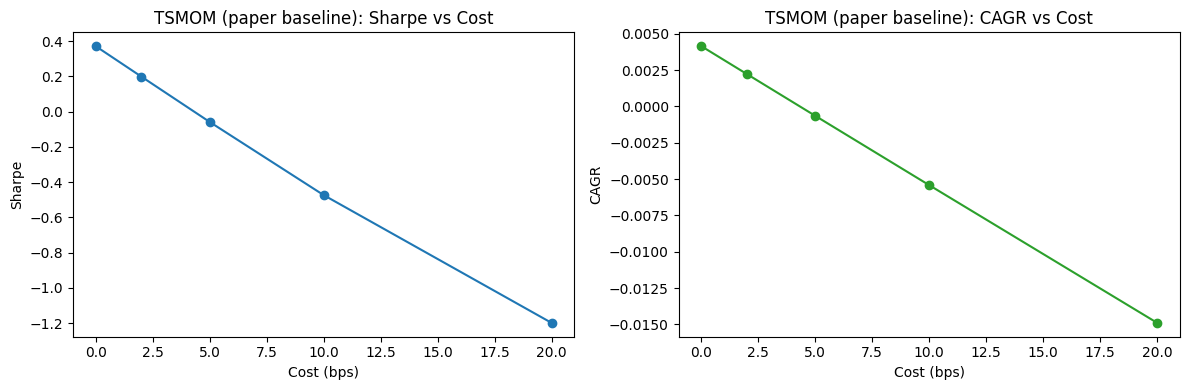

,cost_bps,Sharpe,CAGR,MaxDD,AvgTurnover,TotalCost,AvgGrossExposure,PctInvested
0,0.0,0.372064,0.004144,-0.034191,0.075773,0.000000,0.037986,0.045129
1,2.0,0.199519,0.002224,-0.040803,0.075773,0.038214,0.037986,0.045129
2,5.0,-0.057999,-0.000650,-0.050635,0.075773,0.095534,0.037986,0.045129
3,10.0,-0.473148,-0.005422,-0.119889,0.075773,0.191068,0.037986,0.045129
4,20.0,-1.198633,-0.014897,-0.263683,0.075773,0.382137,0.037986,0.045129


In [5]:
tsmom = pd.read_csv("../data/processed/tsmom_cost_sensitivity.csv")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(tsmom["cost_bps"], tsmom["Sharpe"], marker="o")
ax[0].set_xlabel("Cost (bps)")
ax[0].set_ylabel("Sharpe")
ax[0].set_title("TSMOM (paper baseline): Sharpe vs Cost")

ax[1].plot(tsmom["cost_bps"], tsmom["CAGR"], marker="o", color="tab:green")
ax[1].set_xlabel("Cost (bps)")
ax[1].set_ylabel("CAGR")
ax[1].set_title("TSMOM (paper baseline): CAGR vs Cost")

plt.tight_layout()
plt.show()

tsmom

### Time-Series Momentum: Transaction Cost Sensitivity (Paper-Baseline Configuration)

Configuration now follows the research-style implementation:
- monthly signal construction (`k=12`, `h=1`)
- `t-1` volatility sizing (no look-ahead)
- EWMA volatility (`delta=0.94`)
- equal weighting across active instruments

**Observation:**
- Gross performance is modestly positive at very low costs.
- Performance degrades quickly as costs rise.
- At 10–20 bps, both Sharpe and CAGR are negative in this ETF universe.

**Interpretation:**
Implementation quality and turnover costs remain the binding constraint.

### TSMOM Research Diagnostics

This section mirrors three paper-style diagnostics:
1. lag-persistence profile (1 to 12 months)
2. trend-smile convexity (`market` and `market^2`)
3. passive vs TSMOM cross-asset correlation structure

In [6]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

from src.data import DataConfig, fetch_prices, close_prices, compute_returns
from src.backtest.engine import backtest_positions
from src.strategies.tsmom import TSMOMConfig, generate_positions_tsmom
from src.experiments.tsmom_diagnostics import (
    lag_persistence_table,
    trend_smile_regression,
    avg_pairwise_corr,
)

cfg_data = DataConfig(
    tickers=["SPY", "TLT", "GLD", "HYG", "EFA", "DBC", "VNQ", "UUP"],
    start="2006-01-01",
    end="2026-01-01",
)
prices = fetch_prices(cfg_data)
rets = compute_returns(close_prices(prices))

cfg_tsmom = TSMOMConfig(
    signal_mode="monthly_12_1",
    lookback=12,
    skip_recent=1,
    signal_lag=1,
    hold_rebalances=1,
    use_ewm_vol=True,
    ewma_decay=0.94,
    rebalance="ME",
    equal_weight_active=True,
)

pos = generate_positions_tsmom(rets, cfg_tsmom)
bt = backtest_positions(pos, rets, cost_bps=0.0)

monthly_rets = rets.resample("ME").sum(min_count=1)
tsmom_monthly = bt.returns.resample("ME").sum(min_count=1)
mkt_monthly = monthly_rets.mean(axis=1)

persistence = lag_persistence_table(monthly_rets, max_lag=12)
smile = trend_smile_regression(tsmom_monthly, mkt_monthly)

passive_corr = avg_pairwise_corr(monthly_rets)
ts_sleeves = (pos.shift(1).fillna(0.0) * rets).resample("ME").sum(min_count=1)
tsmom_corr = avg_pairwise_corr(ts_sleeves)

print("Trend smile coefficients:")
for k, v in smile.items():
    print(f"  {k}: {v}")

print(f"\nPassive avg pairwise corr: {passive_corr:.4f}")
print(f"TSMOM avg pairwise corr  : {tsmom_corr:.4f}")

persistence

Trend smile coefficients:
  alpha: 0.00024344139858171443
  beta_mkt: 0.004067137918779709
  beta_mkt2: 0.11689199275093583
  n_obs: 240

Passive avg pairwise corr: 0.1532
TSMOM avg pairwise corr  : 0.1041


,lag_months,avg_beta,avg_tstat,n_assets
0,1,-0.042001,-0.644860,8
1,2,0.005327,0.144942,8
2,3,0.019726,0.548206,8
3,4,0.015213,0.475601,8
4,5,0.004637,0.156437,8
5,6,-0.004357,-0.158956,8
6,7,0.000365,0.025587,8
7,8,-0.008943,-0.384817,8
8,9,-0.012623,-0.578385,8
9,10,-0.010097,-0.489975,8


**Diagnostic Readout:**
- The convexity term (`beta_mkt2`) is positive, consistent with trend-smile behavior.
- TSMOM sleeve correlation is lower than passive long-only correlation in this sample.
- Persistence estimates are mixed in this small ETF universe, so statistical strength is weaker than broad futures evidence.

## Key Takeaways

- Mean reversion remains unstable and negative in this universe under realistic frictions.
- Paper-style TSMOM implementation is now in place (monthly 12-1 signal, t-1 EWMA vol, equal-active averaging).
- TSMOM shows modest gross edge but remains highly cost-sensitive.
- Diagnostics indicate positive convexity and lower cross-asset co-movement than passive sleeves.

This project now includes both performance backtests and research-style diagnostic checks.